In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from astropy.stats import jackknife_stats
import multiprocessing as mp
import time

In [51]:
# UNIFORM RANDOM DISTRIBUTION OF POINTS ON UNIT SPHERE.
def random_spin():
    x = np.random.normal(0, 1, 3)
    x = x/np.sqrt(x@x)
    
    return x

# RETURN THE VALUE OF SPIN MAGNITUDE.
def spin(site):
    i_ = site[0]%n
    j_ = site[1]%n
    s = spin_config[i_][j_]
    if (len(s) == 3):
        spin_val = 1
    elif (len(s) == 2):
        spin_val = 0
        
    return spin_val

# INITIALIZE ENERGY OF THE SYSTEM.
def initialize_energy():
    Energy = 0
    for i in range(n):
        for j in range(n):
            Energy += (J1/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][j]) + dot(spin_config[i][j],spin_config[i][(j+1)%n]))
            Energy += (J2/4)*(dot(spin_config[i][j], spin_config[(i+1)%n][(j+1)%n]) + dot(spin_config[i][j], spin_config[(i+1)%n][(j-1)%n]))
        
    return Energy

In [52]:
# DOT PRODUCT DEFINITION

def dot(v1, v2):
    if (len(v1) == 3 and len(v2) == 3):
        dot_prod = v1@v2
    else:
        dot_prod = 0
        
    return dot_prod

# DISTANCES ON A TORUS

def dist(site1, site2):
    ix = site1[0]
    iy = site1[1]
    jx = site2[0]
    jy = site2[1]
    
    rx = abs(ix - jx)
    if (rx >= n/2):
        distancex = n - rx
    else:
        distancex = rx
        
    ry = abs(iy - jy)
    if (ry >= n/2):
        distancey = n - ry
    else:
        distancey = ry
    
    if (distancex == 0 or distancey == 0):
        distance = 1
        
    elif (distancex == 1 and distancey == 1):
        distance = 2
    
    else:
        print("Error?")
    
    return distance

In [53]:
def make_dimer(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    unpaired_list = []
    for nbr in [[ix+1, iy], [ix-1, iy], [ix, iy+1], [ix, iy-1], [ix-1, iy-1], [ix-1, iy+1], [ix+1, iy-1], [ix+1, iy+1]]:
        if (spin(nbr) == 1):
            unpaired_list.append(nbr)
    
    if(len(unpaired_list)==0):
        return
    
    else:
        unpaired_indices = np.random.choice(len(unpaired_list))
        unpaired_data = unpaired_list[unpaired_indices]
        
        jx = unpaired_data[0]%n
        jy = unpaired_data[1]%n

        if (dist([ix, iy], [jx, jy]) == 1):
            J = J1
        elif(dist([ix, iy], [jx, jy]) == 2):
            J = J2

        # Calculate the change in energy if dimer is formed.
        E_1 = -(3*J)/4
        E_2 = - (J1/4)*(dot(spin_config[ix][iy], spin_config[(ix-1)%n][iy]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][iy]) + dot(spin_config[ix][iy], spin_config[ix][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[ix][(iy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][jy]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][jy]) + dot(spin_config[jx][jy], spin_config[jx][(jy+1)%n]) + dot(spin_config[jx][jy], spin_config[jx][(jy-1)%n]))
        E_3 = - (J2/4)*(dot(spin_config[ix][iy], spin_config[(ix-1)%n][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][(iy-1)%n]) + dot(spin_config[ix][iy], spin_config[(ix-1)%n][(iy+1)%n]) + dot(spin_config[ix][iy], spin_config[(ix+1)%n][(iy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][(jy-1)%n]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][(jy-1)%n]) + dot(spin_config[jx][jy], spin_config[(jx-1)%n][(jy+1)%n]) + dot(spin_config[jx][jy], spin_config[(jx+1)%n][(jy+1)%n]))
        #         E_3 = - (J2/4)*(dot(spin_config[ix], spin_config[(ix - 2)%n]) + dot(spin_config[ix], spin_config[(ix + 2)%n]) + dot(spin_config[jx], spin_config[(jx - 2)%n]) + dot(spin_config[jx], spin_config[(jx + 2)%n]))
        E_4 = (J/4)*(dot(spin_config[ix][iy], spin_config[jx][jy]))

        dE = E_1 + E_2 + E_3 + E_4

        # Metropolis implementation.

        p_accept = min(1, np.exp(-beta*dE))
        if (np.random.random() <= p_accept):
            spin_config[ix][iy] = [jx, jy]
            spin_config[jx][jy] = [ix, iy]
            E += dE

In [54]:
def spin_rotation(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    spin_new = random_spin()
    dS = spin_new - spin_config[ix][iy]
    
    # Calculating change in E.
    dE1= (J1/4)*(dot(dS, spin_config[(ix - 1)%n][iy]) + dot(dS, spin_config[(ix + 1)%n][iy]) + dot(dS, spin_config[ix][(iy - 1)%n]) + dot(dS, spin_config[ix][(iy + 1)%n])) 
    dE2= (J2/4)*(dot(dS, spin_config[(ix - 1)%n][(iy - 1)%n]) + dot(dS, spin_config[(ix + 1)%n][(iy - 1)%n]) + dot(dS, spin_config[(ix - 1)%n][(iy + 1)%n]) + dot(dS, spin_config[(ix + 1)%n][(iy + 1)%n]))
    
    dE = dE1 + dE2
    # Metropolis implementation.
    
    p_accept = min(1, np.exp(-beta*dE))
    
#     print(dE, p_accept)
    if (np.random.random() <= p_accept):
        spin_config[ix][iy] = spin_new
        E += dE

In [55]:
def break_dimer(site):
    global E
    global spin_config

    ix = site[0]
    iy = site[1]
    
    jx = spin_config[ix][iy][0]
    jy = spin_config[ix][iy][1]
    
    if (dist([ix, iy], [jx, jy]) == 1):
        J = J1
    elif(dist([ix, iy], [jx, jy]) == 2):
        J = J2
     
    spin_config_new = np.copy(spin_config)

    # Modifying a copy of the spin configutation.
    
    spin_config_new[ix][iy] = random_spin()
    spin_config_new[jx][jy] = random_spin()
    
    # Calculate the change in energy if dimer is broken.
    E_1 = + (3*J)/4
    E_2 = + (J1/4)*(dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][iy]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][iy]) + dot(spin_config_new[ix][iy], spin_config_new[ix][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[ix][(iy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][jy]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][jy]) + dot(spin_config_new[jx][jy], spin_config_new[jx][(jy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[jx][(jy-1)%n]))
    E_3 = + (J2/4)*(dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][(iy-1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix-1)%n][(iy+1)%n]) + dot(spin_config_new[ix][iy], spin_config_new[(ix+1)%n][(iy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][(jy-1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][(jy-1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx-1)%n][(jy+1)%n]) + dot(spin_config_new[jx][jy], spin_config_new[(jx+1)%n][(jy+1)%n]))
    E_4 = - (J/4)*(dot(spin_config_new[ix][iy], spin_config_new[jx][jy]))

    dE = E_1 + E_2 + E_3 + E_4
    
    # Metropolis implementation.
    
    p_accept = min(1, np.exp(-beta*dE))
    if (np.random.random() <= p_accept):
        spin_config[ix][iy] = spin_config_new[ix][iy]
        spin_config[jx][jy] = spin_config_new[jx][jy]
        E += dE

In [56]:
# MONTE CARLO SWEEP (RANDOM)

def monte_carlo_sweep():
    
    for i in range(n*n):
        
        ix = int(np.random.random()*n)
        iy = int(np.random.random()*n)
        
        site = [ix, iy]
        
        # f tunes the ratio of random spin rotations to dimer formation. Increase f to increase dimer formation.
        f = 0.5

        # If the chosen site has a free spin.
        if (spin(site) == 1):
            if (f <= np.random.random()):
                spin_rotation(site)
            else:
                make_dimer(site)

        # If the chosen site is part of a dimer.        
        elif (spin(site) == 0):
            break_dimer(site)

    # One MC Sweep Over.
            
    free_spins = []
    
    count_dimer = 0
    for i in range(n):
        for j in range(n):
            if (spin([i, j]) == 1):
                free_spins.append([i, j])
            else:
                count_dimer +=1
    
    if(len(free_spins)==0):
        iene = E/(n*n)
        stot = np.zeros((3), dtype=np.float64)
        mstag = np.zeros((3), dtype=np.float64)
        ndimer = count_dimer
    
        return iene, stot, mstag, ndimer
    
    else:
        S = np.zeros((3), dtype=np.float64)
        M_stag = np.zeros((3), dtype=np.float64)
        
        for sites in free_spins:
            S += np.array(spin_config[sites[0]][sites[1]])
            M_stag += np.array(spin_config[sites[0]][sites[1]])*((-1)**(sites[0]+sites[1]))

    iene = E/(n*n)
    stot = S/(n*n)
    mstag = M_stag/(n*n)
    ndimer = count_dimer

    return iene, stot, mstag, ndimer

In [62]:
# SIMULATION FUNCTION (INITIALIZE THE LATTICE BEFOREHAND)

def simulation(n, T, J2byJ1, nsweeps):
    
    global J2
    global beta
    
    J2 = J2byJ1*J1
    beta = 1/T
    
    for i in range(n):
        for j in range(n):
            spin_config[i][j] = random_spin()

    global E 
    E = initialize_energy()

    E_list = []
    S_list = []
    M_list = []
    D_list = []
    
    neqsweeps = int(0.1*nsweeps)

    for i in range(nsweeps):
            E_meas, S_meas, M_meas, D_meas = monte_carlo_sweep()
            
            if (i > neqsweeps):
                E_list.append(E_meas)
                S_list.append(S_meas)
                M_list.append(M_meas)
                D_list.append(D_meas)
            
#             if(i%100 == 0):
#                 print(i)
                
    E_list = np.array(E_list)
    S_list = np.array(S_list)
    M_list = np.array(M_list)
    D_list = np.array(D_list)
    
    magS_list = np.sqrt(np.array(S_list).T[0]**2 + np.array(S_list).T[1]**2 + np.array(S_list).T[2]**2)
    magM_list = np.sqrt(np.array(M_list).T[0]**2 + np.array(M_list).T[1]**2 + np.array(M_list).T[2]**2)
    
#     plt.plot(E_list, '.-')
#     plt.xlabel("Monte Carlo time")
#     plt.ylabel(r'$E/n^2$')
#     plt.grid(True)
#     plt.show()

#     plt.plot(magS_list, '.-')
#     plt.xlabel("Monte Carlo time")
#     plt.ylabel(r'$S_z/n^2$')
#     # plt.ylim([-1,1])
#     plt.grid(True)
#     plt.show()
    
#     print(magS_list)
                
    test_statistic = np.mean
    
    avg_E, bias_E, stderr_E, conf_interval_E = jackknife_stats(E_list, test_statistic, 0.95)
    avg_S, bias_S, stderr_S, conf_interval_S = jackknife_stats(magS_list, test_statistic, 0.95)
    avg_M, bias_M, stderr_M, conf_interval_M = jackknife_stats(magM_list, test_statistic, 0.95)
    avg_D, bias_D, stderr_D, conf_interval_D = jackknife_stats(D_list, test_statistic, 0.95)
    
    data = [T, J2byJ1, avg_E, stderr_E, avg_S, stderr_S, avg_M, stderr_M, avg_D, stderr_D]
    
    with open('J1J2_model_1.csv', 'a', newline='') as myfile:
        wr = csv.writer(myfile)
        wr.writerow(data)

In [3]:
# DEFINE THE LATTICE.

n = 10
J1 = 4
# T = 0.1
# J2byJ1 = 0.1
nsweeps = int(5.0e2)

T_list = np.arange(0.2, 4.2, 0.2)
J2byJ1_list = np.arange(0.1, 1.1, 0.1)

global spin_config
spin_config = np.zeros((n, n), dtype=np.ndarray)

for i in range(n):
    for j in range(n):
        spin_config[i][j] = random_spin()

with open('J1J2_model_1.csv', 'w', newline='') as myfile:
        wr = csv.writer(myfile)

NameError: name 'random_spin' is not defined

In [77]:
for J2byJ1 in J2byJ1_list:
    for T in T_list:
        simulation(n, T, J2byJ1, nsweeps)

In [9]:
import csv
T_list = np.arange(0.2, 4.2, 0.2)

rows = []
with open("J1J2_model_1.csv", 'r') as file:
    csvreader = csv.reader(file)
    for row in csvreader:
        rows.append([float(i) for i in row])

staggered_magnetization = np.array(rows).T[6]
no_of_dimers = np.array(rows).T[8]

N = len(T_list)
M = len(J2byJ1_list)

# print(staggered_magnetization)
# print(no_of_dimers)

staggered_magnetization = np.reshape(staggered_magnetization, (M,N)).T
no_of_dimers = np.reshape(no_of_dimers, (M,N)).T

print(staggered_magnetization)


[[2.02534802e-02 2.26958811e-02 2.15337803e-02 1.92193844e-02
  1.37947668e-02 5.81593089e-05 1.37095783e-02 1.45773755e-02
  2.06511751e-02 1.40159483e-02]
 [1.64412086e-02 1.47976497e-02 1.53931772e-02 1.71640490e-02
  7.61173629e-03 1.49841867e-02 3.72977145e-03 1.18631193e-02
  6.09722368e-03 1.06179471e-02]
 [2.36561175e-02 2.66599213e-02 2.75858036e-02 2.65087557e-02
  2.51361128e-02 2.36097861e-02 2.31372512e-02 2.33423059e-02
  2.07428333e-02 1.86540147e-02]
 [3.89705934e-02 3.91995020e-02 3.84527492e-02 3.61729474e-02
  3.66382711e-02 3.48075825e-02 3.32631943e-02 3.25524622e-02
  3.09390438e-02 2.88497065e-02]
 [5.12259857e-02 4.90323973e-02 4.77717066e-02 4.67284900e-02
  4.62234788e-02 4.34846034e-02 4.10191809e-02 3.88158540e-02
  3.62274062e-02 3.47832540e-02]
 [6.22369025e-02 5.75259893e-02 5.39799706e-02 5.36379016e-02
  4.98775666e-02 4.94836379e-02 4.91403398e-02 4.64292999e-02
  4.28475485e-02 4.11647001e-02]
 [6.55271139e-02 6.27174752e-02 6.07932776e-02 5.96410336e

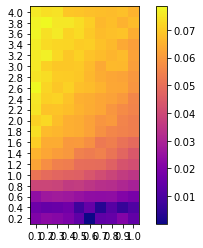

In [5]:
plt.imshow(staggered_magnetization , cmap = 'plasma' , interpolation = 'nearest')
# plt.imshow(staggered_magnetization , cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 1)

ax = plt.gca();

# # Major ticks
ax.set_xticks(np.arange(0, M, 1))
ax.set_yticks(np.arange(0, N, 1))

# # Labels for major ticks
ax.set_xticklabels(J2byJ1_list.round(1))
ax.set_yticklabels(T_list.round(2))
ax.invert_yaxis()

plt.colorbar()

plt.show()

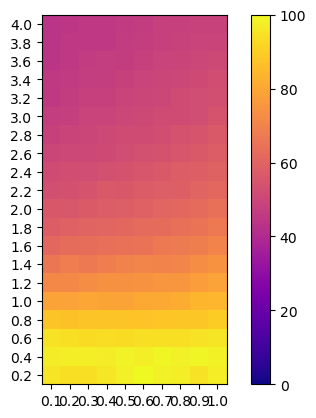

In [82]:
plt.imshow(no_of_dimers, cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 100)
ax = plt.gca();

# # Major ticks
ax.set_xticks(np.arange(0, M, 1))
ax.set_yticks(np.arange(0, N, 1))

# # Labels for major ticks
ax.set_xticklabels(J2byJ1_list.round(1))
ax.set_yticklabels(T_list.round(1))
ax.invert_yaxis()

plt.colorbar()

plt.show()

In [ ]:
spin_state = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if (len(spin_config[i][j]) == 3):
            spin_state[i][j] = 1

spin_state
plt.imshow(np.array(spin_state) , cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 1)
# plt.pcolormesh(np.array(spin_state), edgecolors='k', linewidth=2)
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)
plt.show()

In [34]:
# Blue = Dimer
# Yellow = Free Spins

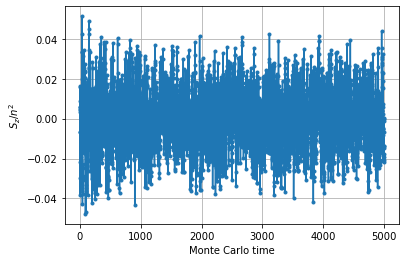

In [35]:
plt.plot(np.array(S_list).T[2], '.-')
plt.xlabel("Monte Carlo time")
plt.ylabel(r'$S_z/n^2$')
# plt.ylim([-1,1])
plt.grid(True)
plt.show()

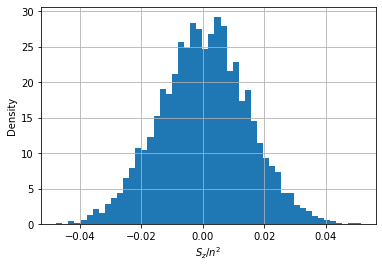

In [36]:
plt.hist(np.array(S_list).T[2], density = True, bins = 50)
plt.xlabel(r'$S_z/n^2$')
plt.ylabel("Density")
plt.grid(True)
plt.show()

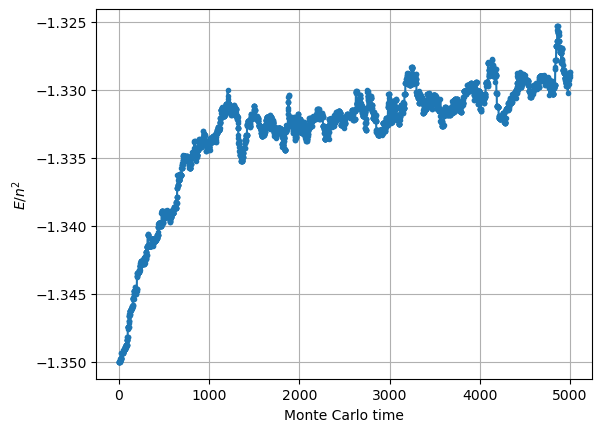

In [91]:
plt.plot(E_list, '.-')
plt.xlabel("Monte Carlo time")
plt.ylabel(r'$E/n^2$')
plt.grid(True)
plt.show()

In [ ]:
# # DEFINE THE LATTICE.
# n = 10
# # beta = 4
# J1 = 4
# J2 = 1.5


# global spin_config
# spin_config = np.zeros((n, n), dtype=np.ndarray)

# for i in range(n):
#     for j in range(n):
# #         spin_config[i][j] = random_spin()
#         spin_config[i][j] = np.array([0.57735027, 0.57735027, 0.57735027])*((-1)**(i+j))
    
# for beta in (np.concatenate((np.arange(0.1, 1.1, 0.1), np.arange(2, 12, 2)))):
#     global E 
#     E = initialize_energy()

#     # print(spin_config, E)

#     nsweeps = int(5.0e3)

#     E_list = []
#     S_list = []

#     for i in range(nsweeps):
#             E_meas, S_meas = monte_carlo_sweep()

#             E_list.append(E_meas)
#             S_list.append(S_meas)

#     count_dimer = 0
#     for i in range(n):
#         for j in range(n):
#             if (len(spin_config[i][j]) == 2):
#                 count_dimer +=1

#     print(spin_config)
#     print(count_dimer)
#     print(beta)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
[[array([0.60925582, 0.60512668, 0.51247346])
  array([-0.58787607, -0.6342674 , -0.50210216])
  array([0.70419171, 0.33571276, 0.62562847])
  array([-0.57618011, -0.56145895, -0.59395314])
  array([0.75287127, 0.3994447 , 0.52309539])
  array([-0.71477834, -0.36661611, -0.59555399])
  array([0.6034854 , 0.46244632, 0.64957584])
  array([-0.57015738, -0.56964619, -0.59196602])
  array([0.57998698, 0.54893776, 0.60189903])
  array([-0.44170063, -0.73664609, -0.51210652])]
 [array([-0.60345461, -0.70523901, -0.37212964])
  array([0.67118878, 0.63982651, 0.3743363 ])
  array([-0.69567937, -0.51915771, -0.49649319])
  array([0.71458812, 0.38833159, 0.58186115])
  array([-0.5380744 , -0.46627561, -0.70218445])
  array([0.73321751, 0.33729497, 0.59044406])
 

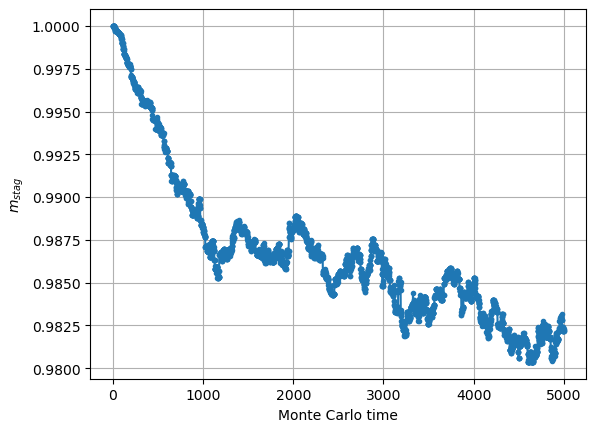

In [16]:
# DEFINE THE LATTICE.
n = 10
beta = 50
J1 = 4
J2 = 1.3

global spin_config
spin_config = np.zeros((n, n), dtype=np.ndarray)

for i in range(n):
    for j in range(n):
#         spin_config[i][j] = random_spin()
        spin_config[i][j] = np.array([0.57735027, 0.57735027, 0.57735027])*((-1)**(i+j))
    
global E 
E = initialize_energy()

# print(spin_config, E)

nsweeps = int(5.0e3)

E_list = []
S_list = []

for i in range(nsweeps):
        E_meas, S_meas = monte_carlo_sweep()
            
        E_list.append(E_meas)
        S_list.append(S_meas)
                
        if(i%100 == 0):
            print(i)

count_dimer = 0
for i in range(n):
    for j in range(n):
        if (len(spin_config[i][j]) == 2):
            count_dimer +=1
        
print(spin_config)
print(count_dimer)

st_mag = np.sqrt(np.array(S_list).T[0]**2 + np.array(S_list).T[1]**2 + np.array(S_list).T[2]**2)

plt.plot(st_mag, '.-')
plt.xlabel("Monte Carlo time")
plt.ylabel(r'$m_{stag}$')
# plt.ylim([-1,1])
plt.grid(True)
plt.show()

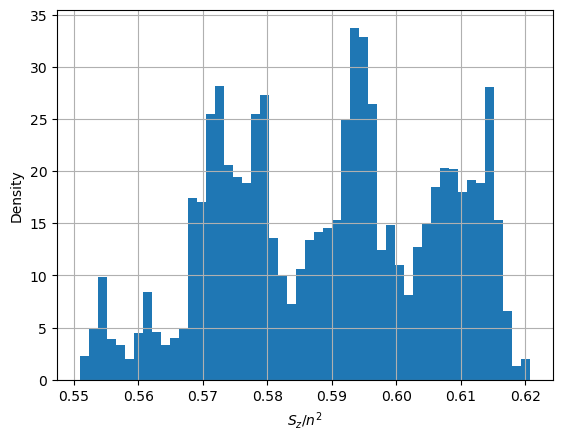

In [11]:
plt.hist(np.array(S_list).T[2], density = True, bins = 50)
plt.xlabel(r'$S_z/n^2$')
plt.ylabel("Density")
plt.grid(True)
plt.show()

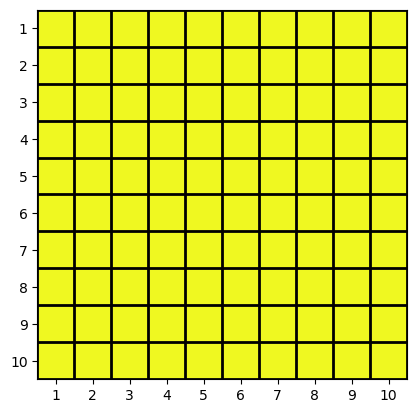

In [12]:
spin_state = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if (len(spin_config[i][j]) == 3):
            spin_state[i][j] = 1

spin_state
plt.imshow(np.array(spin_state) , cmap = 'plasma' , interpolation = 'nearest', vmin = 0, vmax = 1)
# plt.pcolormesh(np.array(spin_state), edgecolors='k', linewidth=2)
ax = plt.gca();

# Major ticks
ax.set_xticks(np.arange(0, 10, 1))
ax.set_yticks(np.arange(0, 10, 1))

# Labels for major ticks
ax.set_xticklabels(np.arange(1, 11, 1))
ax.set_yticklabels(np.arange(1, 11, 1))

# Minor ticks
ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
ax.set_yticks(np.arange(-.5, 10, 1), minor=True)

# Gridlines based on minor ticks
ax.grid(which='minor', color='k', linestyle='-', linewidth=2)

# Remove minor ticks
ax.tick_params(which='minor', bottom=False, left=False)
plt.show()

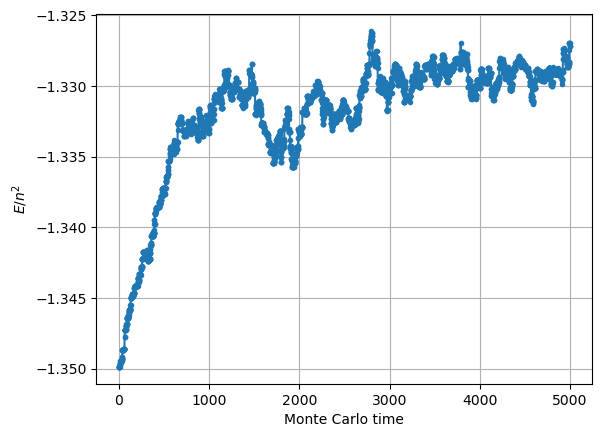

In [13]:
plt.plot(E_list, '.-')
plt.xlabel("Monte Carlo time")
plt.ylabel(r'$E/n^2$')
plt.grid(True)
plt.show()

In [76]:
# Add a snippet to calculate number of J1 and J2 dimers separately.

In [ ]:
# Package this into a function.

In [24]:
a = 1/c
c = 2
print(a)

NameError: name 'c' is not defined

In [35]:

mylist = np.array([1,2,3,4])



In [68]:
stderr2

3.0127506811328852

In [29]:
np.abs(np.array([np.array([-1, 2, -3]), np.array([-2, 3, -6])]))

array([[1, 2, 3],
       [2, 3, 6]])